---
title: "Language model random number generator"
date: "2024-10-22"
draft: false
tags:
- language_models
image: images/llm_rand_18_0.png
---

I had the idea to try and use a language model as a random number generator.
I didn't expect it to actually work as a uniform random number generator but was curious to see what the distribution of numbers would look like.

My goal was to prompt the model to generate a number between 1 and 100.
I could also vary the temperature to see how that changed the distribution of the numbers.

First, we import a bunch of libraries we'll use later

In [64]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import scipy
import seaborn as sns

from openai import OpenAI

Next, we'll define functions to call `ollama` using the `openai` client, a prompt to generate a number between 1 and 100 and a parsing function that will deal with the messiness of the model outputs.
The parser is very permissive.
It grabs the first digit it finds in the output string, even if it's part of another string.
For example:

In [96]:
s = "asd123fgh456"
re.search(r'\d+', s)
int(match.group())

123

In [97]:
def create_openai_client():
    return OpenAI(
        base_url="http://localhost:11434/v1",
        # required, but unused
        api_key="ollama",
    )


def generate_random_number(client, model, temperature):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system",
                "content": "You are a random number generator that provides a number between 1 and 100.",
            },
            {
                "role": "user",
                "content": "Generate a random number between 1 and 100. Provide the output in the following format: 'Random number: X', where X is the generated number. Ensure the number is an integer and do not include any additional text or explanations.",
            },
        ],
        temperature=temperature,
        max_tokens=10,
    )
    return response.choices[0].message.content

def parse_random_number(output, min_=1, max_=100):
    if output:
        match = re.search(r'\d+', output)
        if match:
            try:
                random_number = int(match.group())
                if random_number < min_ or random_number > max_:
                    return None
                return random_number
            except ValueError:
                print("Failed to convert parsed value to integer:", match.group())
                return None
        else:
            print("No number found in output:", output)
            return None
    else:
        print("No output received from the model")
        return None


Here's an example of the whole thing end to end with `llama3.2` and temperature 1.5

In [98]:
client = create_openai_client()
output = generate_random_number(client, "llama3.2", 1.5)
print(output)
number = parse_random_number(output)
number

Random number: 53


53

We're also doing to do some runs with high temperatures, like 9 and 11.
They outputs from the models using those temperatures are weird, but we can parse them some of the time.

In [99]:
client = create_openai_client()
output = generate_random_number(client, "qwen2.5", 11)
print(output)
number = parse_random_number(output)
number

randomumber：Observers1BekK


1

There are lots of good, small models we can try this experiment on.
We're going to loop through them and several different temperature values, attempting to generate 500 values for each model-temperature combination.
If we can't parse a number from the model response, we just move on.
We're going to count the number of successful samples later.
We write the results to jsonl files, which makes it easier to resume the experiment in case something goes wrong along the way.
Running this takes a while - 10s of minutes on my M3 MBP.

In [ ]:
client = create_openai_client()
models = [
    "llama3.2",
    "phi3.5",
    "qwen2.5",
    "gemma2",
    "mistral",
]
results = {}
temperatures = [0.25, 0.5, 1, 3, 5, 7, 9, 11]
sample_count = 500

os.makedirs("results", exist_ok=True)

for model in models:
    results[model] = {}
    for temperature in temperatures:
        jsonl_filename = f"results/{model}_{temperature}.jsonl"
        if os.path.exists(jsonl_filename):
            print(f"Skipping {model} at temperature {temperature} - file already exists")
            with open(jsonl_filename, 'r') as jsonl_file:
                numbers = [json.loads(line)['number'] for line in jsonl_file]
            results[model][temperature] = numbers
        else:
            numbers = []
            with open(jsonl_filename, 'w') as jsonl_file:
                for _ in range(sample_count):
                    output = generate_random_number(client, model, temperature=temperature)
                    number = parse_random_number(output)
                    if number is not None:
                        numbers.append(number)
                        json.dump({"model": model, "temperature": temperature, "number": number}, jsonl_file)
                        jsonl_file.write('\n')
            results[model][temperature] = numbers


Once we have the data in jsonl files, we can take a look at the distributions of the generated numbers

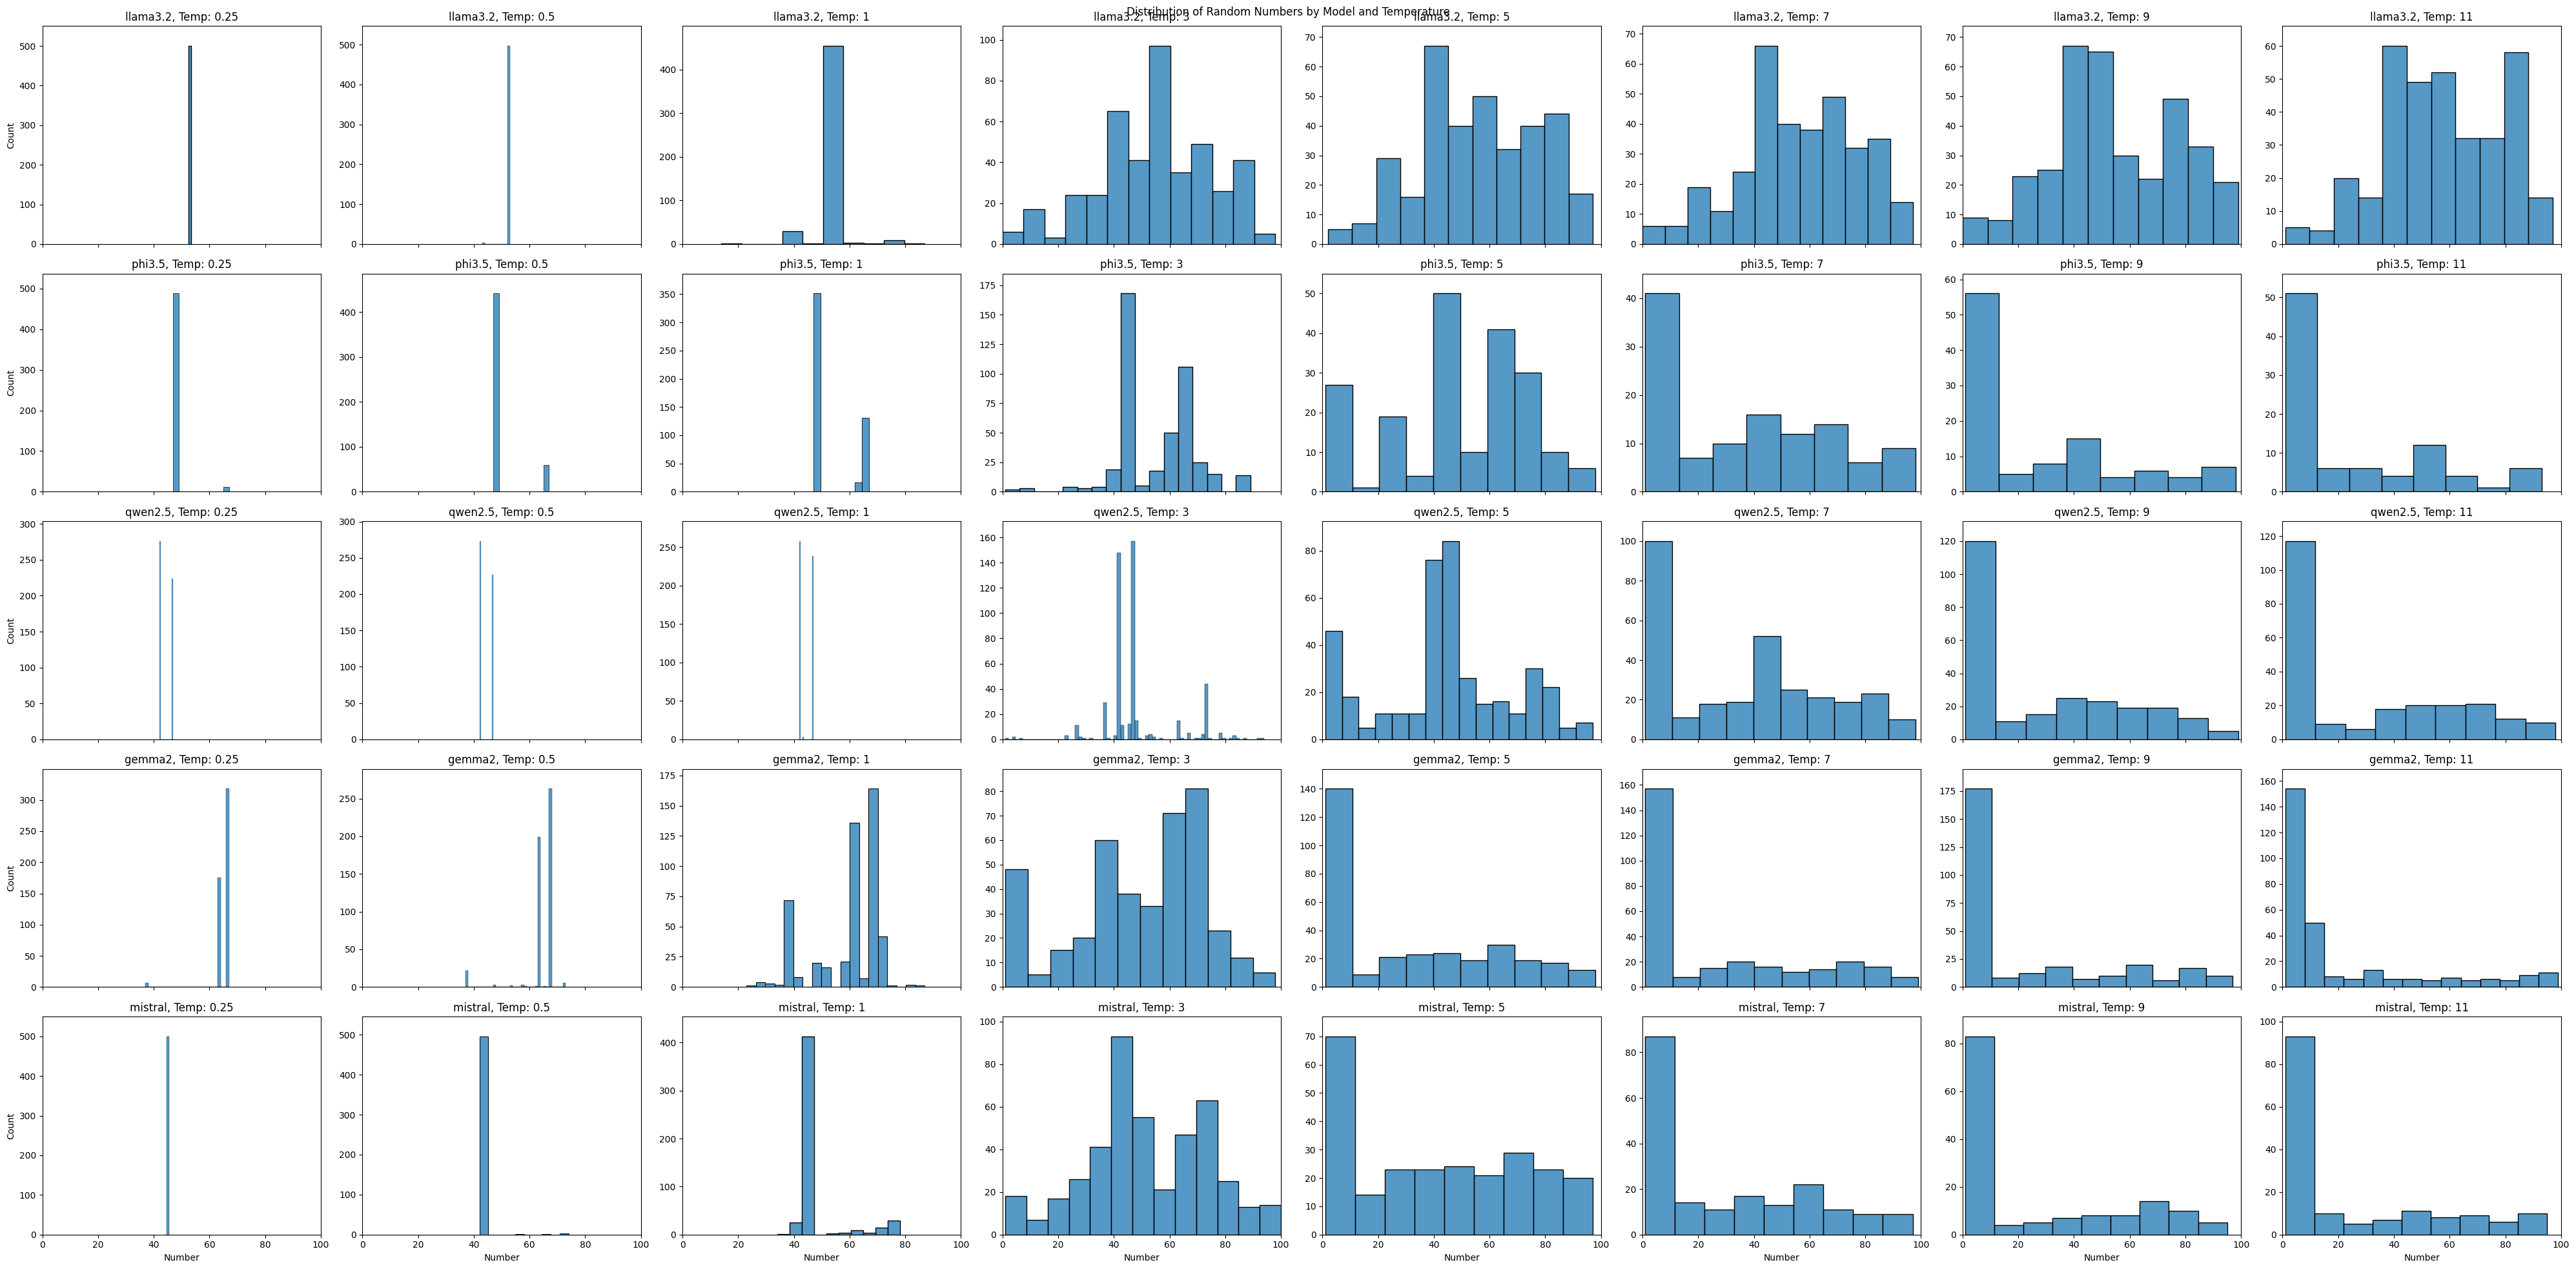

In [112]:
data = []

for model in models:
    for temp in temperatures:
        jsonl_filename = f"results/{model}_{temp}.jsonl"
        if os.path.exists(jsonl_filename):
            with open(jsonl_filename, 'r') as jsonl_file:
                for line in jsonl_file:
                    entry = json.loads(line)
                    data.append((entry['model'], entry['temperature'], entry['number']))

df = pd.DataFrame(data, columns=['Model', 'Temperature', 'Number'])

num_models = len(models)
num_temps = len(temperatures)
fig, axes = plt.subplots(num_models, num_temps, figsize=(5*num_temps, 4*num_models), sharex=True, sharey=False)
fig.suptitle('Distribution of Random Numbers by Model and Temperature')

for i, model in enumerate(models):
    for j, temp in enumerate(temperatures):
        ax = axes[i, j] if num_models > 1 else axes[j]
        model_temp_data = df[(df['Model'] == model) & (df['Temperature'] == temp)]['Number']

        sns.histplot(data=model_temp_data, kde=False, ax=ax)

        ax.set_title(f'{model}, Temp: {temp}')
        ax.set_xlabel('Number' if i == num_models - 1 else '')
        ax.set_ylabel('Count' if j == 0 else '')
        ax.set_xlim(0, 100)

        ylim = ax.get_ylim()
        highest_bar = ax.patches[0].get_height()
        for patch in ax.patches[1:]:
            if patch.get_height() > highest_bar:
                highest_bar = patch.get_height()
        ax.set_ylim(0, highest_bar * 1.1)

plt.tight_layout()
plt.show()


That's a lot of data.
My takeaways:

- Models with simple prompts, at long temperatures, generally output the same couple of numbers, even though we ask for a "random" number
- `llama3.2` outputs a pretty stable distribution of numbers across temperatures
- All the models some sort of bi-modal behavior between temperatures 3 and 7
- My permissive number parsing probably masks some pretty bad behavior by the model

Let's take a look at that last point now.
We're going to plot the number of valid outputs per model across temperature to see how well they followed instructions and actually output an integer.
Keep in mind, our integer parsing is much more permissive than our instructions, so an output that can't be parsed is a pretty serious failure by the model.
Here's an example what these look like:

In [108]:
client = create_openai_client()
output = generate_random_number(client, "mistral", 11)
print(output)
number = parse_random_number(output)
number

random value in java script without additional logic:\``
No number found in output: random value in java script without additional logic:\``


Yikes!
This is why we use models at temperatures in the 0-2 range.
With that, let's see how these models breakdown.

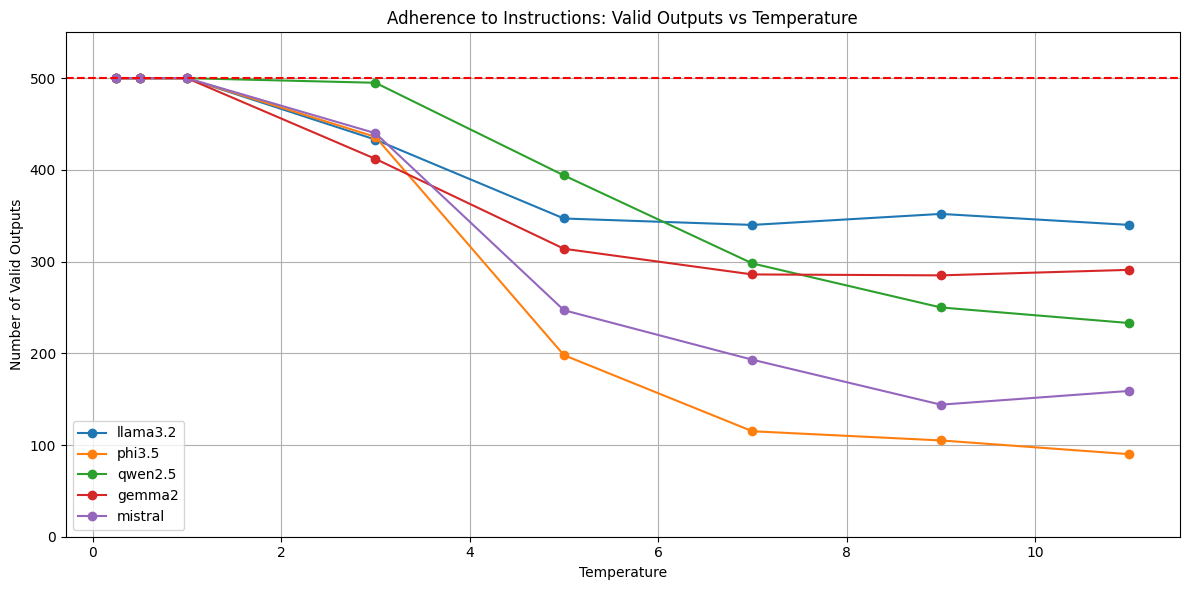

In [110]:
valid_outputs = df.groupby(['Model', 'Temperature']).size().reset_index(name='Valid Outputs')

plt.figure(figsize=(12, 6))

for model in models:
    model_data = valid_outputs[valid_outputs['Model'] == model]
    plt.plot(model_data['Temperature'], model_data['Valid Outputs'], marker='o', label=model)

plt.xlabel('Temperature')
plt.ylabel('Number of Valid Outputs')
plt.title('Adherence to Instructions: Valid Outputs vs Temperature')
plt.legend()
plt.grid(True)

plt.ylim(0, 550)

plt.axhline(y=500, color='r', linestyle='--', label='Expected Outputs')

plt.tight_layout()
plt.show()


As we'd expect, we start to have problems between temperatures 1 and 3.

Hopefully, you never find yourself in a position where you're using a language model to generate a random number but it was a fun experiment nonetheless.